# Test the parameter set of the Enertech cells
In this notebook, we show how to use pybamm to reproduce the experimental results for the Enertech cells (LCO-G). To see all of the models and submodels available in PyBaMM, please take a look at the documentation [here](https://pybamm.readthedocs.io/en/latest/source/models/index.html).

In [1]:
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

When you load a model in PyBaMM it builds by default. Building the model sets all of the model variables and sets up any variables which are coupled between different submodels: this is the process which couples the submodels together and allows one submodel to access variables from another. If you would like to swap out a submodel in an exisitng battery model you need to load it without building it by passing the keyword `build=False`

In [2]:
model = pybamm.lithium_ion.DFN(
    build=False,options = {"particle": "Fickian diffusion", "thermal": "lumped"}
)


We can get the parameter set `Ai2020` for the model, which includes the mechanical properties required by the mechanical model.

In [3]:
param = model.default_parameter_values
# # Below commands are used to add the mechanical parameters missing from other parameter sets 
import pandas as pd
mechanics = pd.read_csv("pybamm/input/parameters/lithium-ion/mechanicals/lico2_graphite_Ai2020/parameters.csv", 
                        index_col=0, comment="#", skip_blank_lines=True, header=None)[1][1:].dropna().astype(float).to_dict()
param.update(mechanics, check_already_exists=False)

chemistry = pybamm.parameter_sets.Ai2020
param = pybamm.ParameterValues(chemistry=chemistry)
experiment05C = pybamm.Experiment(["Discharge at 0.5C until 3 V"])
experiment1C = pybamm.Experiment(["Discharge at 1C until 3 V"])
experiment2C = pybamm.Experiment(["Discharge at 2C until 3 V"])
var = pybamm.standard_spatial_vars
var_pts = {
  var.x_n: 50,
  var.x_s: 50,
  var.x_p: 50,
  var.r_n: 20,
  var.r_p: 20,
}

sim1 = pybamm.Simulation(
    model, 
    var_pts=var_pts,
    experiment=experiment05C,
    parameter_values=param,
    solver=pybamm.CasadiSolver(dt_max=0.001)
)
solution05C = sim1.solve()


Load experimental results of the Enertech cells, Ref. Ai et al. JES 2020
https://iopscience.iop.org/article/10.1149/2.0122001JES

In [4]:
# load experimental results
import pandas as pd
path = "pybamm/input/discharge_data/Enertech_cells/"
data_Disp_01C=pd.read_csv (path + "0.1C_discharge_displacement.txt", delimiter= '\s+',header=None)
data_Disp_05C=pd.read_csv (path + "0.5C_discharge_displacement.txt", delimiter= '\s+',header=None)
data_Disp_1C=pd.read_csv (path + "1C_discharge_displacement.txt", delimiter= '\s+',header=None)
data_Disp_2C=pd.read_csv (path + "2C_discharge_displacement.txt", delimiter= '\s+',header=None)
data_V_01C=pd.read_csv (path + "0.1C_discharge_U.txt", delimiter= '\s+',header=None)
data_V_05C=pd.read_csv (path + "0.5C_discharge_U.txt", delimiter= '\s+',header=None)
data_V_1C=pd.read_csv (path + "1C_discharge_U.txt", delimiter= '\s+',header=None)
data_V_2C=pd.read_csv (path + "2C_discharge_U.txt", delimiter= '\s+',header=None)
data_T_05C=pd.read_csv (path + "0.5C_discharge_T.txt", delimiter= '\s+',header=None)
data_T_1C=pd.read_csv (path + "1C_discharge_T.txt", delimiter= '\s+',header=None)
data_T_2C=pd.read_csv (path + "2C_discharge_T.txt", delimiter= '\s+',header=None)

Plot the results.

2020-10-22 21:30:07,561 - [WARNING] legend._parse_legend_args(1247): No handles with labels found to put in legend.
2020-10-22 21:30:07,569 - [WARNING] legend._parse_legend_args(1247): No handles with labels found to put in legend.
2020-10-22 21:30:07,585 - [WARNING] legend._parse_legend_args(1247): No handles with labels found to put in legend.


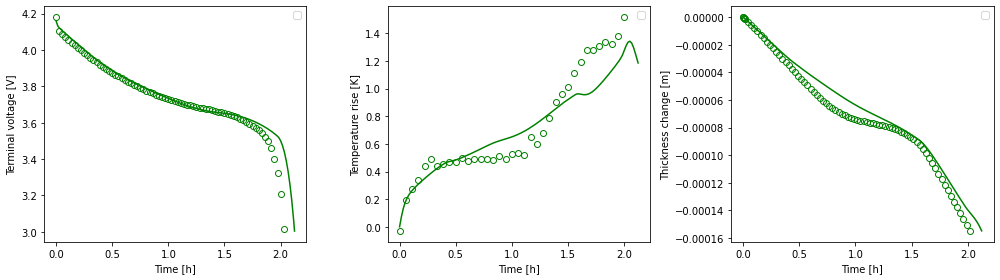

In [5]:

t_all05C = solution05C["Time [h]"].entries
V_n05C = solution05C["Terminal voltage [V]"].entries
T_n05C = solution05C["Volume-averaged cell temperature [K]"].entries - param["Initial temperature [K]"]
L_x05C = solution05C["Cell thickness change [m]"].entries
f, (ax1, ax2,ax3) = plt.subplots(1, 3 ,figsize=(14,4))
#ax1.plot(t_all2C, V_n2C,'r-',label="Simulation")
#ax1.plot(data_V_2C.values[::30,0]/3600, data_V_2C.values[::30,1],'ro',markerfacecolor='none',label="Experiment")
ax1.plot(t_all05C, V_n05C,'g-')
ax1.plot(data_V_05C.values[::100,0]/3600, data_V_05C.values[::100,1],'go',markerfacecolor='none')
#ax1.plot(t_all1C, V_n1C,'b-')
#ax1.plot(data_V_1C.values[::50,0]/3600, data_V_1C.values[::50,1],'bo',markerfacecolor='none')
ax1.legend()
#plt.xlim(0, 3600);
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Terminal voltage [V]")

#ax2.plot(t_all2C, T_n2C,'r-',label="Simulation")
#ax2.plot(data_T_2C.values[0:1754:50,0]/3600, data_T_2C.values[0:1754:50,1],'ro',markerfacecolor='none',label="Experiment")
ax2.plot(t_all05C, T_n05C,'g-')
ax2.plot(data_T_05C.values[0:7301:200,0]/3600, data_T_05C.values[0:7301:200,1],'go',markerfacecolor='none')
#ax2.plot(t_all1C, T_n1C,'b-')
#ax2.plot(data_T_1C.values[0:3598:100,0]/3600, data_T_1C.values[0:3598:100,1],'bo',markerfacecolor='none')
ax2.legend()
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Temperature rise [K]")
#plt.xlim(0, 3600);

#ax3.plot(t_all2C, L_x2C,'r-',label="Simulation")
#ax3.plot(data_Disp_2C.values[0:1754:5,0]/3600, data_Disp_2C.values[0:1754:5,1]-data_Disp_2C.values[0,1],'ro',markerfacecolor='none',label="Experiment")
ax3.plot(t_all05C, L_x05C,'g-')
ax3.plot(data_Disp_05C.values[0:1754:10,0]/3600, data_Disp_05C.values[0:1754:10,1]-data_Disp_05C.values[0,1],'go',markerfacecolor='none')
#ax3.plot(t_all1C, L_x1C,'b-')
#ax3.plot(data_Disp_1C.values[0:1754:10,0]/3600, data_Disp_1C.values[0:1754:10,1]-data_Disp_1C.values[0,1],'bo',markerfacecolor='none')
ax3.legend()
ax3.set_xlabel("Time [h]")
ax3.set_ylabel("Thickness change [m]")
#plt.xlim(0, 3600);
f.tight_layout()
f.show()


Stress data below are from Fig. 6 in Ai et al. JES 2020 https://iopscience.iop.org/article/10.1149/2.0122001JES

In [6]:
cs_n_rav = solution05C["R-averaged negative particle concentration"].entries
print(cs_n_rav[:,64])
#print(cs_n_rav[:,32])
#print(cs_n_rav[:,2])
#cs_p_rav = solution05C["R-averaged positive particle concentration"].entries
#print(cs_p_rav[:,64])

[0.55280438 0.55264475 0.55232489 0.55184532 0.55120668 0.55040965
 0.54945487 0.54834273 0.54707336 0.54564642 0.544061   0.54231545
 0.54040712 0.53833218 0.53608529 0.5336592  0.53104423 0.52822763
 0.52519262 0.52191704 0.5183714  0.51451589 0.51029564 0.50563287
 0.50041335 0.4944618  0.48749269 0.47899288 0.46788737 0.45134874
 0.41908004 0.35564742 0.31308814 0.29376721 0.28403034 0.27793202
 0.27319244 0.26899114 0.26504308 0.26124631 0.25755826 0.25395521
 0.25041996 0.24693805 0.24349642 0.24008283 0.23668544 0.23329241
 0.2298916  0.2264701 ]
[0.79364695 0.793357   0.7927696  0.79187637 0.790664   0.78911334
 0.78719799 0.78488227 0.78211821 0.77884121 0.77496373 0.77036604
 0.76488294 0.75828585 0.75026291 0.74041315 0.72830925 0.71374939
 0.69725651 0.68034241 0.6647691  0.65147976 0.64045813 0.63122808
 0.62326367 0.61614932 0.60959764 0.60342022 0.59749429 0.59173749
 0.58609131 0.58051104 0.57495947 0.56940303 0.56380902 0.55814346
 0.55236891 0.54644193 0.5403096  0.53